# Do Science!
# Experiments: 
    -Free Running: 
        -/glade/campaign/cisl/aiml/wchapman/CAM_runs/f.e21.DAcompset.f09_d025_free_MJO_1982
        - path_tofiles=/glade/campaign/cisl/aiml/wchapman/CAM_runs/' + modvers + '/atm/hist/*h1*.nc
    -Nudge No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982
    -Nudge Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3
        - path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
    -DA No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982
    -DA Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982/
    -obs
        -/glade/scratch/wchapman/TEMPERAI/
# set model to run:

In [1]:
modvers_comp = 'f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3'

In [2]:
import numpy as np
import numpy.ma as ma

import pandas as pd
import glob
import scipy
import copy

#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy
from datetime import datetime
import os
import importlib

from eofs.xarray import Eof

#filtering tool: 
from scipy.signal import butter
from scipy import signal
import glob

import scipy.io as sio
import scipy.fftpack as fftpack

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import xarray as xr

import scipy as sp
import scipy.ndimage

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
######
from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
from windspharm.examples import example_data_path
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.tools import prep_data, recover_data
import spharm.spharm

## Functions

In [3]:
def is_djf(month):
    return (month == 12) | (month == 1) | (month == 2)
# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

#low pass filter
def filt_low(ts,band_low_ind):
    Z = np.fft.fft(ts)
    Zlow = np.copy(Z)
    Zlow[band_low_ind:-band_low_ind] = 0.0
    X_filtered = np.real(np.fft.ifft(Zlow))
    return X_filtered

def low_pass_DA(DA,ind_low):
    DA_out_xr = xr.zeros_like(DA)
    DA_out_np = np.array(DA)
    lat = DA['lat']
    lon = DA['lon']
    
    for lala in range(len(lat)):
        for lolo in range(len(lon)):
            do_pass = DA_out_np[:,lala,lolo]
            DA_out_np[:,lala,lolo]=filt_low(do_pass,ind_low)
            
    DA_out_xr[:,:,:] = DA_out_np
    return DA_out_xr

def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    bsmooth = xr.zeros_like(Patty)
    bsmooth[:,:] =y 
    return bsmooth

def project_pat_FBS(DS,Pat_day_M,termdo,lat_ar,lon_ar,flat_list):
    tots=[]
    for ii in range(-40,40):

        get_dt_list = flat_list+np.timedelta64(ii,'D')
        get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year >= 1982]
        get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year <= 2010]

        term_day_ii = DS[termdo].sel(time =  get_dt_list,lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).mean('time')
        term_day_ii = term_day_ii
        
        term_day_ii = smooth_it(term_day_ii)
        
        if termdo=='StreamFunction_tend':
            term_day_ii = term_day_ii/86400

        #cosine weight: 
        coslat = np.cos(np.deg2rad(DS[termdo].sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).coords['lat'].values))
        numer = (term_day_ii*Pat_day_M*np.expand_dims(coslat,[1])).sum()
        denomer = (Pat_day_M**2*np.expand_dims(coslat,[1])).sum()

        Projection = numer/denomer
        tots.append(float(Projection.values))
    
    return np.array(tots)

def fix_EOF(C_for,Pats):
    Pats=[Pats]
    C_for_rep = xr.zeros_like(C_for)
    for Pt in Pats:
        print(Pt)
        if Pt == 'PNA':
            latdo = [75,30]
            londo = [180,220]

        if Pt == 'NPO':
            latdo = [60,89]
            londo = [0,360]

        if Pt == 'NAM':
            latdo = [60,89]
            londo = [0,360]

        if Pt == 'SAM':
            latdo = [-89,-60]
            londo = [0,360]

        if Pt == 'PSA1':
            latdo = [-89,-60]
            londo = [0,360]

        if Pt == 'PSA2':
            latdo = [-89,-60]
            londo = [0,360]

        if Pt == 'NAO':
            latdo = [60,15]
            londo = [0,360]
        Replace_EOF = np.zeros_like(C_for[Pt].values)
        Replace_PC  = np.zeros_like(C_for[Pt+'_PC'])
        
        if np.sum(C_for[Pt].sel(lat=slice(latdo[0],latdo[1]),lon=slice(londo[0],londo[1]))).values < 0:
            print('flipped')
            Replace_EOF[:,:] = C_for[Pt].values*-1
            Replace_PC[:] = C_for[Pt+'_PC'].values*-1     
        else:
            Replace_EOF[:,:] = C_for[Pt].values
            Replace_PC[:] = C_for[Pt+'_PC'].values

        C_for_rep[Pt].values = Replace_EOF
        C_for_rep[Pt+'_PC'].values = Replace_PC
    return C_for_rep


# This function computes the inverse Laplacian of a given field over time using the `xarray` and `spherepack` libraries.
def Inv_lap(DS,feild_do):

    # Assert that both input arguments are of the expected xarray types and have the same length of time dimension.
    assert len(DS['time']) == len(feild_do['time']), 'fields must have the same length time'
    assert isinstance(feild_do, xr.DataArray), 'feild_do must be a Data Array'
    assert isinstance(DS, xr.Dataset), 'DS must be a dataset'

    # Initialize an xarray Data Array `ilap_feild` of the same size as the `DS['U']` variable.
    ilap_feild = xr.zeros_like(DS['U'])

    # Loop over each time step of the input field to compute the inverse Laplacian at each time step.
    for ee,ii in enumerate(range(len(DS['time']))):

        # Get the spherepack object S for computing the inverse Laplacian.
        S = w._api.s

        # Prepare the input field for the inverse Laplacian calculation by converting it to spectral space using the `prep_data()` function.
        scalar_field, shape_info = prep_data((feild_do.isel(time=ii).data), "yx")

        # Compute the inverse Laplacian using the `spherepack.invlap()` function.
        scalar_field_spec = S.grdtospec(scalar_field)
        ilap_spec = spharm.spharm._spherepack.invlap(scalar_field_spec, S.rsphere)

        # Convert the computed inverse Laplacian from spectral space to physical space using the `spectogrd()` function.
        ilapNINO = recover_data(S.spectogrd(ilap_spec), shape_info)

        # Store the computed inverse Laplacian field in the `ilap_feild` Data Array at the appropriate time index.
        ilap_feild[ee,:,:] = ilapNINO
    
    ilap_feild=ilap_feild.to_dataset(name=feild_do.name+'_invlap')
    # Return the computed inverse Laplacian field.
    return ilap_feild


# This function computes the inverse Laplacian of a given field over time using the `xarray` and `spherepack` libraries.
def Inv_lap_1t(DS,feild_do):

    # Initialize an xarray Data Array `ilap_feild` of the same size as the `DS['U']` variable.
    ilap_feild = xr.zeros_like(DS['U'])


    # Get the spherepack object S for computing the inverse Laplacian.
    S = w._api.s

    # Prepare the input field for the inverse Laplacian calculation by converting it to spectral space using the `prep_data()` function.
    scalar_field, shape_info = prep_data((feild_do.data), "yx")

    # Compute the inverse Laplacian using the `spherepack.invlap()` function.
    scalar_field_spec = S.grdtospec(scalar_field)
    ilap_spec = spharm.spharm._spherepack.invlap(scalar_field_spec, S.rsphere)

    # Convert the computed inverse Laplacian from spectral space to physical space using the `spectogrd()` function.
    ilapNINO = recover_data(S.spectogrd(ilap_spec), shape_info)

    # Store the computed inverse Laplacian field in the `ilap_feild` Data Array at the appropriate time index.
    ilap_feild[:,:] = ilapNINO
    
    ilap_feild=ilap_feild.to_dataset(name=feild_do.name+'_invlap')
    # Return the computed inverse Laplacian field.
    return ilap_feild


def regress_out_seasonal(ts):
    # Assume this is daily data... will not work if it isn't
    # Get the length of the input time series
    nt = len(ts)
    # Generate an array of time indices from 1 to nt
    time = np.arange(1, nt+1) # each value is one day
    # Create a matrix A2 with columns for the intercept and various seasonal cycles
    A2 = np.array([np.ones(nt), time, np.sin(2*np.pi*time/365.25), np.cos(2*np.pi*time/365.25),
                   np.sin(4*np.pi*time/365.25), np.cos(4*np.pi*time/365.25),
                   np.sin(6*np.pi*time/365.25), np.cos(6*np.pi*time/365.25),
                   np.sin(8*np.pi*time/365.25), np.cos(8*np.pi*time/365.25)]).T 
    # Compute the Moore-Penrose pseudoinverse of A2 to obtain regression coefficients
    x_dot_inv = np.dot(scipy.linalg.inv(np.dot(A2.T, A2)), np.dot(A2.T, ts))
    # Compute the linear fit of the input time series using the regression coefficients and A2
    fit = np.dot(A2, x_dot_inv)
    # Return the input time series with the seasonal variation removed by subtracting the fit
    return ts - fit

def divy(u,v): 
    w = VectorWind(u,v)
    div = w.divergence()
    return div

def Fast_Regress_lag(DA,pc_low,lag=0):
    
    pc_low = pc_low.isel(time=slice(30,-30))
    DA = DA.isel(time=slice(30-lag,-30-lag))
    
    
    
    DA_djf_lag = DA.isel(time=np.where(is_djf(pc_low['time.month']))[0])
    pc_low_djf = pc_low.sel(time=is_djf(pc_low['time.month']))
    
    #print('PC_time:',str(pc_low.time.values[0]))
    #print('DA_time:',(str(DA.time.values[0])))
    
    
    latshape=len(DA_djf_lag['lat'])
    lonshape=len(DA_djf_lag['lon'])
    bb = ma.dot(DA_djf_lag.stack(allpoints=['lat','lon']).T,pc_low_djf['pc_low'].values)/(len(pc_low_djf.time)-1)
    patdone = bb.reshape([latshape,lonshape])
    C_for = xr.Dataset(
                  {
                    'pattern': (["lat", "lon"],patdone), 
                },
                coords={
                    "lat":np.array(DA['lat']),
                    "lon":np.array(DA['lon']),
                },)
    
    return C_for


def project_reg_pat_FBS(DA_Pat,DA_Do,lat_ar,lon_ar,pc_low):
    tots=[]
    for ii in range(-20,20):
        Pat_day_M = Fast_Regress_lag(DA_Pat,pc_low,lag=ii).sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1]))
        Pat_day_M = smooth_it(Pat_day_M['pattern'])
        
        term_day_ii = Fast_Regress_lag(DA_Do,pc_low,lag=ii).sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1]))
        term_day_ii = smooth_it(term_day_ii['pattern'])
    
        #cosine weight: 
        coslat = np.cos(np.deg2rad(DA_Do.sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).coords['lat'].values))
        numer = (term_day_ii*Pat_day_M*np.expand_dims(coslat,[1])).sum()
        denomer = (Pat_day_M**2*np.expand_dims(coslat,[1])).sum()

        Projection = numer
        tots.append(float(Projection.values))
    
    return np.array(tots)

def project_pat_FBS_v2(DS,termdo,lat_ar,lon_ar,flat_list):
    tots=[]
    for ii in range(-40,40):
        
        

        get_dt_list = flat_list+np.timedelta64(ii,'D')
        get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year >= 1982]
        get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year <= 2010]
        
        Pat_day_M = DS.sel(time=get_dt_list)['StreamFunction_L'].sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).mean('time')
        term_day_ii = DS[termdo].sel(time =  get_dt_list,lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).mean('time')
        term_day_ii = term_day_ii
        
        term_day_ii = smooth_it(term_day_ii)
        
        if termdo=='StreamFunction_tend':
            term_day_ii = term_day_ii/86400

        #cosine weight: 
        coslat = np.cos(np.deg2rad(DS[termdo].sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).coords['lat'].values))
        numer = (term_day_ii*Pat_day_M*np.expand_dims(coslat,[1])).sum()
        denomer = (Pat_day_M**2*np.expand_dims(coslat,[1])).sum()

        Projection = numer/denomer
        tots.append(float(Projection.values))
    
    return np.array(tots)


def get_dats_range(PNA_ts,star_,en_):
    for ee,ii in enumerate(np.arange(star_,en_+1)): 
        if ee == 0:
            PNA_totdats = PNA_ts+np.timedelta64(ii,'D')
        else: 
            PNA_totdats = np.concatenate([PNA_totdats,PNA_ts+np.timedelta64(ii,'D')])
    
    
    get_dt_list = PNA_totdats[pd.DatetimeIndex(PNA_totdats).year >= 1982]
    get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year <= 2010]
    

    return sorted(get_dt_list)



# Experiments: 
    -Free Running: 
        -/glade/campaign/cisl/aiml/wchapman/CAM_runs/f.e21.DAcompset.f09_d025_free_MJO_1982
        - path_tofiles=/glade/campaign/cisl/aiml/wchapman/CAM_runs/' + modvers + '/atm/hist/*h1*.nc
    -Nudge No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982
    -Nudge Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3
        - path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
    -DA No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982
    -DA Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982/
    -obs
        -/glade/scratch/wchapman/TEMPERAI/

doing obs
...combining terms...
...loaded...
....planetary...
....Stream Function...
...done...
...regressing out seasonal cycle...
...monthly means...
..select DJF...
...doing EOF...
EOF


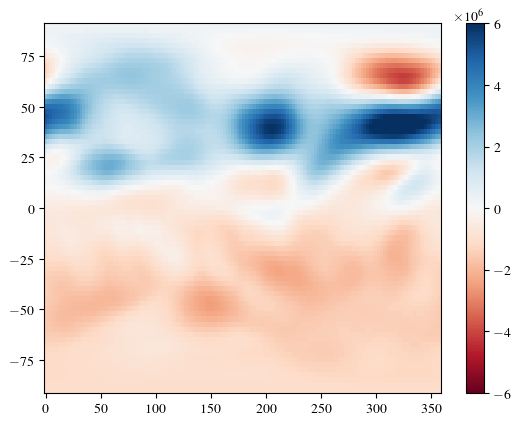

...Project PCs and Rescale...


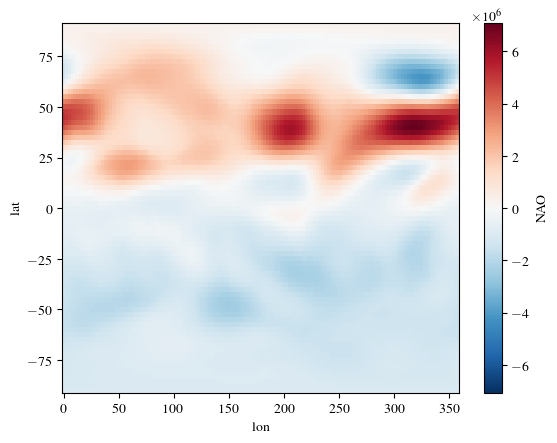

NAO


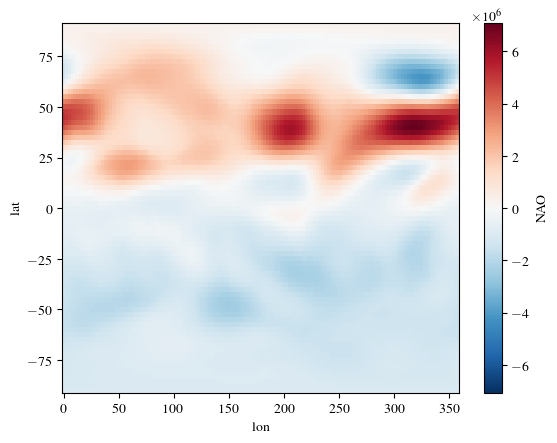

...these look good?
Aleutian low should be blue
CPU times: user 42.1 s, sys: 42.2 s, total: 1min 24s
Wall time: 2min 55s


In [4]:
%%time
mods = False #True if model False if obs.
lev=500
lev_500 = 500
if mods:
    ######## input datapath
    fil_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.UV'+str(lev)+'.ERAgrid.198201-201012.nc'
    feldstein_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.Feldstein.consistent.'+str(lev)+'.ERAgrid.198201-201012.nc'
    modvers_500mb = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.UV'+str(lev_500)+'.ERAgrid.198201-201012.nc'
    ##########

    ######## output datapath
    file_path = '/glade/scratch/wchapman/DA_ML_data/Random_Data/'
    tot_out = file_path+modvers_comp + '_'+str(lev)+'mb_'+'High_Low_Pass_SUBSEASONAL_TAN_longer_climo_consistent.nc'
    ##########

    ######## use xarray to open data
    DS_cera0 = xr.open_dataset(tot_out).squeeze()
    DS_cera0.load()
    feldstein_out = xr.open_dataset(feldstein_out_comp).squeeze()
    DS_500 = xr.open_dataset(modvers_500mb).squeeze()
    ########
else:
    print('doing obs')
    ######## input datapath
    modvers_comp = 'ERAi.h1'
    fil_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp + '.UV'+str(lev)+'mb.197901-201812.nc'
    ##########

    ######## output datapath
    file_path = '/glade/scratch/wchapman/DA_ML_data/Random_Data/'
    tot_out = file_path+modvers_comp + '_'+str(lev)+'mb_'+'High_Low_Pass_SUBSEASONAL_TAN_longer_climo_consistent.nc'
    feldstein_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp + '.Feldstein.consistent.'+str(lev)+'.ERAgrid.198201-201012.nc'
    modvers_500mb = '/glade/scratch/wchapman/ADF/ERAi.h1.UV500mb.197901-201812.nc'
    ##########

    ######## use xarray to open data
    DS_cera0 = xr.open_dataset(tot_out).squeeze()
    DS_cera0.load()
    feldstein_out = xr.open_dataset(feldstein_out_comp).squeeze()
    DS_500 = xr.open_dataset(modvers_500mb).squeeze()
    ########
    ## Ensure that the DS is oriented N->S
    
print('...combining terms...')
feldstein_out['T1']=DS_cera0['T1']
feldstein_out['T2']=DS_cera0['T2']
feldstein_out['T3']=DS_cera0['T3']
feldstein_out['T3_1']=DS_cera0['T3_1']
feldstein_out['T3_2']=DS_cera0['T3_2']
feldstein_out['Tan_Tot']=(DS_cera0['T1']+DS_cera0['T2']+DS_cera0['T3'])
feldstein_out['term1term2']=(feldstein_out['term1']+feldstein_out['term2'])
feldstein_out['term2term3']=(feldstein_out['term2']+feldstein_out['term3'])
feldstein_out['term1term2term3']=(feldstein_out['term1']+feldstein_out['term2']+feldstein_out['term3'])
feldstein_out['term2term3term4']=(feldstein_out['term2']+feldstein_out['term3']+feldstein_out['term4'])
feldstein_out['linear2']=(feldstein_out['term1'])+(feldstein_out['term2'])+(feldstein_out['term3'])+(0.5*feldstein_out['term4'])
print('...loaded...')


#vector wind
w = VectorWind(DS_500['U'],DS_500['V'])
print('....planetary...')
#f/g
pvrt_g = (w.planetaryvorticity()/9.81)
#streamfunction
print('....Stream Function...')
sf_ = w.streamfunction()
print('...done...')

print('...regressing out seasonal cycle...')
sf_nosea=np.zeros_like(sf_)
sf_nosea_xr=xr.zeros_like(sf_)
lat = DS_cera0['lat']
lon = DS_cera0['lon']
SFdo = np.array(sf_)

for lala in range(lat.shape[0]):
    for lolo in range(lon.shape[0]):
        dsf = copy.deepcopy(SFdo[:,lala,lolo])
        sf_nosea[:,lala,lolo]=regress_out_seasonal(dsf)
sf_nosea_xr[:,:,:]=sf_nosea

DS_500['sf_mr']=sf_nosea_xr
DS_500['sf_mr'].attrs['units']='m**2 s**-1'
DS_500['sf_mr'].attrs['standard name']='stream function wind removing first 4 harmonics'     

DS_500['sf']=sf_
DS_500['sf'].attrs['units']='m**2 s**-1'
DS_500['sf'].attrs['standard name']='sf wind removing first 4 harmonics'     

print('...monthly means...')
mean_month = DS_500.resample(time='1MS').mean('time')
mean_month = mean_month.isel(time=slice(0,-1))

print('..select DJF...')
mean_month_djf  = mean_month.sel(time=is_djf(mean_month['time.month']))

print('...doing EOF...')
latdo = [80,20]
londo = [-90,40]
latshape=len(mean_month_djf['lat'])
lonshape=len(mean_month_djf['lon'])
getmode=0

DS_SEA = mean_month_djf['sf_mr']
DA_do = copy.deepcopy(DS_SEA)
DA_do.coords['lon'] = (DS_SEA.coords['lon'] + 180) % 360 - 180
DA_do = DA_do.sortby(DA_do.lon).sel(lat=slice(latdo[0],latdo[1]),lon=slice(londo[0],londo[1]))
print('EOF')
coslat = np.cos(np.deg2rad(DA_do.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(DA_do, weights=wgts)
pc1 = solver.pcs(npcs=10, pcscaling=1).sel(mode=getmode)
pc_neg = [str(tt.values)[0:7] for tt in mean_month_djf.isel(time=np.where(pc1<-1)[0]).time]
pc_pos = [str(tt.values)[0:7] for tt in mean_month_djf.isel(time=np.where(pc1>1)[0]).time]
eof1 = solver.eofsAsCovariance(neofs=1)
bb = ma.dot((DS_SEA-(DS_SEA.mean(['time']))).stack(allpoints=['lat','lon']).T,pc1)/(len(pc1)-1)
patdone = bb.reshape([latshape,lonshape])
patdone

plt.pcolor(mean_month_djf['lon'],mean_month_djf['lat'],patdone,cmap='RdBu',vmin=-6e6,vmax=6e6)
plt.colorbar()
plt.show()

print('...Project PCs and Rescale...')
DS_SEA = DS_500['sf_mr']
DA_do = copy.deepcopy(DS_SEA)
DA_do.coords['lon'] = (DS_SEA.coords['lon'] + 180) % 360 - 180
DA_do = DA_do.sortby(DA_do.lon).sel(lat=slice(latdo[0],latdo[1]),lon=slice(londo[0],londo[1]))
pseudo_pcs = solver.projectField(DA_do,neofs=1,eofscaling=1)

C_for = xr.Dataset(
                  {
                    'NAO': (["lat", "lon"],patdone), 
                    'NAO_PC':(["time"], pseudo_pcs.values.squeeze())
                },
                coords={
                    "lat":np.array(DS_500['lat']),
                    "lon":np.array(DS_500['lon']),
                    "time":pseudo_pcs['time'].values,
                },)
C_for.attrs["title"] = "EOFs of member"
C_for['NAO'].plot()
plt.show()
C_for = fix_EOF(C_for,'NAO')
C_for['NAO'].plot()
plt.show()
print('...these look good?')
print('Aleutian low should be blue')

In [5]:
feldstein_out_roll = copy.deepcopy(feldstein_out)
feldstein_out_roll.coords['lon'] = (feldstein_out.coords['lon'] + 180) % 360 - 180
feldstein_out_roll = feldstein_out_roll.sortby(feldstein_out_roll.lon)

In [6]:
%%time
Z = np.fft.fft(C_for['NAO_PC'])
Yfft = Z/np.size(C_for['NAO_PC'])
freq = np.fft.rfftfreq(len(C_for['NAO_PC']))
fs = 1 #day

perd = fs/freq[1:]
val_8d, ind_8d = find_nearest(perd,value=1)
print('cutoff index 8day:',ind_8d)
ts_low = filt_low(C_for['NAO_PC'],ind_8d)
pc_low = xr.Dataset({'pc_low': (["time"],ts_low)},
                coords={
                    "time":pseudo_pcs['time'],
                },)

times_plus = []
times_minus = []

for ee,pvals in enumerate(pc_low['pc_low']):    
    peetree = pvals.values
    
    if ee==len(pc_low['pc_low'])-1:
        break
    
    if peetree>1.5:
        forw1 = pc_low['pc_low'][ee+1].values
        back1 = pc_low['pc_low'][ee-1].values
        if (peetree > forw1) & (peetree>back1):

            if np.isin([12,1,2],pd.to_datetime(str(pvals.time.values)[0:10]).month).any():
                times_plus.append([pvals.time.values])
        
    if peetree<-1.5:
        # print('bingo')
        forw1 = pc_low['pc_low'][ee+1].values
        back1 = pc_low['pc_low'][ee-1].values
        
        # print(back1,peetree,forw1)
        if (peetree < forw1) & (peetree<back1):
            # print('in')
            #times_minus.append([pvals.time.values])
    
            if np.isin([12,1,2],pd.to_datetime(str(pvals.time.values)[0:10]).month).any():
                times_minus.append([pvals.time.values])
            
    else:
        continue
        
flat_list_plus = [item for sublist in times_plus for item in sublist]
flat_list_minus = [item for sublist in times_minus for item in sublist]
NAO_dats_plus = pd.to_datetime(flat_list_plus)
NAO_dats_minus = pd.to_datetime(flat_list_minus)

cutoff index 8day: 5843
CPU times: user 2.73 s, sys: 8.39 ms, total: 2.74 s
Wall time: 4.93 s


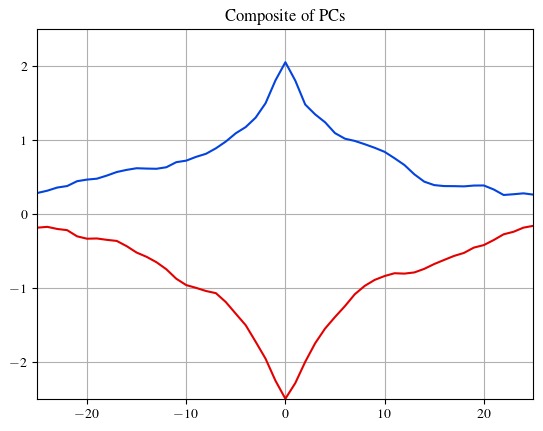

In [7]:
bbm = []
bbp = []

for ii in range(-40,40):
    get_dt_list_pos = NAO_dats_plus+np.timedelta64(ii,'D')
    get_dt_list_pos = get_dt_list_pos[pd.DatetimeIndex(get_dt_list_pos).year >= 1982]
    get_dt_list_pos = get_dt_list_pos[pd.DatetimeIndex(get_dt_list_pos).year <= 2010]
    
    get_dt_list_neg = NAO_dats_minus+np.timedelta64(ii,'D')
    get_dt_list_neg = get_dt_list_neg[pd.DatetimeIndex(get_dt_list_neg).year >= 1982]
    get_dt_list_neg = get_dt_list_neg[pd.DatetimeIndex(get_dt_list_neg).year <= 2010]

    bbm.append(pc_low.sel(time=get_dt_list_neg)['pc_low'].mean('time').values)
    bbp.append(pc_low.sel(time=get_dt_list_pos)['pc_low'].mean('time').values)
    
plt.plot(np.arange(-40,40),bbm,color='xkcd:red')
plt.plot(np.arange(-40,40),bbp,color='xkcd:blue')
plt.grid(True)
plt.xlim([-25,25])
plt.ylim([-2.5,2.5])
plt.title('Composite of PCs')
plt.show()

# Create a new xarray with the data and time index
DS_pc_composite = xr.Dataset({'Pos_pc': (['index'], bbp),
                 'Neg_pc': (['index'], bbm),
                 'pc_low': (['time'],pc_low['pc_low'].values)},
                coords={'index': np.arange(-40,40),
                        'time_PNA_minus': NAO_dats_minus,
                        'time_PNA_plus':NAO_dats_plus,
                        'time':pc_low['pc_low'].time})


## get an average between 7 and 4 days: 
- optimally weight 

In [8]:
%%time 
f_day=-7
l_day=-4
YEARS_PLUS =np.unique(get_dats_range(NAO_dats_plus,f_day,l_day+1))
DA_do_1 = (feldstein_out_roll.sel(time=YEARS_PLUS)['T1'])
DA_do_2 = (feldstein_out_roll.sel(time=YEARS_PLUS)['T2'])
DA_do_3 = (feldstein_out_roll.sel(time=YEARS_PLUS)['T3'])
DA_do_4 = (feldstein_out_roll.sel(time=YEARS_PLUS)['term7'])/86400

DA_do_actual = feldstein_out_roll.sel(time=YEARS_PLUS)['StreamFunction_tend']/86400/86400
DA_do_actual = (DA_do_actual)

for ee,tt in enumerate(DA_do_actual.time):
    DA_do_1[ee,:,:] = smooth_it(DA_do_1.sel(time=tt)).values
    DA_do_2[ee,:,:] = smooth_it(DA_do_2.sel(time=tt)).values
    DA_do_3[ee,:,:] = smooth_it(DA_do_3.sel(time=tt)).values
    DA_do_actual[ee,:,:] = smooth_it(DA_do_actual.sel(time=tt)).values
    
T1_weight = xr.zeros_like(DA_do_actual.isel(time=0))
T2_weight = xr.zeros_like(DA_do_actual.isel(time=0))
T3_weight = xr.zeros_like(DA_do_actual.isel(time=0))

for lala in range(len(lat)):
    for lolo in range(len(lon)):
        ts = DA_do_actual[:,lala,lolo]
        A2 = np.stack([np.array(DA_do_1[:,lala,lolo]),np.array(DA_do_2[:,lala,lolo]),np.array(DA_do_3[:,lala,lolo])]).T
        x_dot_inv = np.dot(scipy.linalg.inv(np.dot(A2.T, A2)), np.dot(A2.T, ts))
        T1_weight[lala,lolo]=x_dot_inv[0]
        T2_weight[lala,lolo]=x_dot_inv[1]
        T3_weight[lala,lolo]=x_dot_inv[2]
        
DA_do_actual = (DA_do_actual).mean('time')

CPU times: user 20.3 s, sys: 583 ms, total: 20.9 s
Wall time: 45 s


3
2
1
0


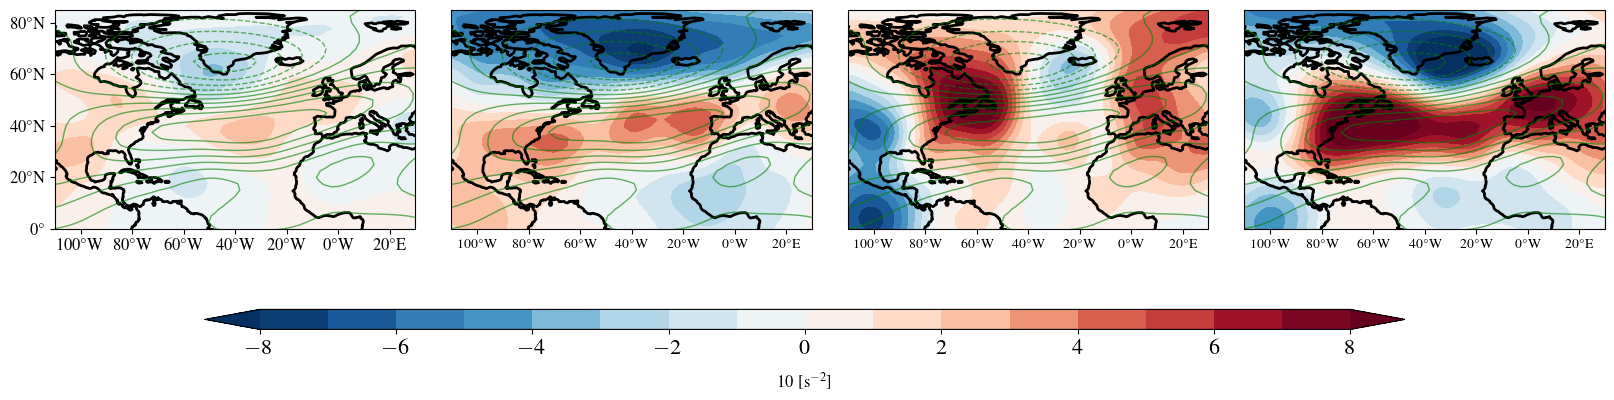

CPU times: user 1.59 s, sys: 627 ms, total: 2.21 s
Wall time: 5.92 s


In [9]:
%%time 

# DA_do = (DA_do_1+DA_do_2+DA_do_3).mean('time')
# DA_do = smooth_it(DA_do)
# DA_do_actual = (DA_do_actual).mean('time')
############# 
clevs = np.arange(-200,210,10)
# clevs = np.delete(clevs,np.floor(clevs.shape[0]/2).astype(int))
bluey = mpl.cm.get_cmap('RdBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
whitez = np.array([1, 1, 1, 1])
newcolors[int(newcolors.shape[0]/2):int(newcolors.shape[0]/2)+1, :] = whitez
cmapzzz = ListedColormap(newcolors)
# ############# 

############# 
clevs2 = np.arange(-8,9,1)
# clevs2 = np.delete(clevs2,np.floor(clevs.shape[0]/2).astype(int))
bluey = mpl.cm.get_cmap('RdBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
whitez = np.array([1, 1, 1, 1])
newcolors[int(newcolors.shape[0]/2):int(newcolors.shape[0]/2)+1, :] = whitez
cmapzzz2 = ListedColormap(newcolors)
# ############# 

proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True,subplot_kw={'projection': proj},figsize=(20,4))
# ax = axes.ravel()

for ee,axs in reversed(list(enumerate(axes.ravel()))):
    print(ee)
    if ee ==3: 
        DA_do = (DA_do_3+DA_do_2+DA_do_1).mean('time')
    if ee ==2:
        DA_do = DA_do_3.mean('time')
    if ee ==1:
        DA_do = DA_do_2.mean('time')
    if ee ==0:
        DA_do = DA_do_1.mean('time')
    
    proj = ccrs.PlateCarree(central_longitude=0)
    axs.coastlines('110m',lw=2)
    DA_do = smooth_it(DA_do)
    ff=axs.contourf(feldstein_out_roll.lon,feldstein_out_roll.lat,DA_do,extend='both',levels=clevs2,cmap=cmapzzz2,transform=proj)
    DA_do_sf = feldstein_out_roll.sel(time=YEARS_PLUS)['StreamFunction_L'].mean('time')
    DA_do_sf = smooth_it(DA_do_sf)
    ff2=axs.contour(feldstein_out_roll.lon,feldstein_out_roll.lat,DA_do_sf/1e10,levels= clevs,colors='g',transform=proj,linewidths=1,alpha=0.6)

    
    axs.tick_params(labelsize=10) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    lat_formatter = LatitudeFormatter()
    axs.set_xticks(np.arange(-180,200,20), crs=ccrs.PlateCarree())
    axs.xaxis.set_major_formatter(lon_formatter)
    axs.set_extent([250,390,0,85], crs=ccrs.PlateCarree()) 
    # axs.set_title('... Low-High ...',fontsize=34)
    
axs.set_yticks(np.arange(-60,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.tick_params(labelsize=12) 
axs.set_extent([250,390,0,85], crs=ccrs.PlateCarree()) 
fig.subplots_adjust(wspace=0.1,bottom=0.25)

cbar_ax = fig.add_axes([0.2, 0.04, 0.6, 0.05])
cb2  = fig.colorbar(ff, cax=cbar_ax,ticks=clevs2[::2],orientation='horizontal')
cb2.ax.tick_params(labelsize=16) 
cb2.set_label('10 [s$^{-2}$]',fontsize=12,labelpad=10)
mode='NAO'
# plt.savefig(os.getcwd()+'/Figures_out/' +mode+'_4terms_positive_'+modvers_comp+'_'+str(lev)+'_hpa.png', dpi=200,bbox_inches='tight')
plt.show()

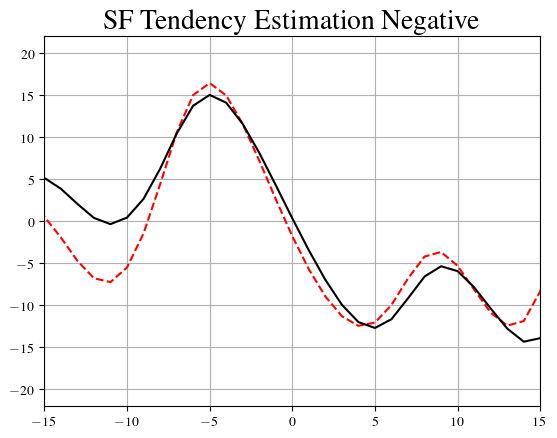

CPU times: user 2min 3s, sys: 8.48 s, total: 2min 11s
Wall time: 2min 29s


In [10]:
%%time 

lat_ar = [80,20]
lon_ar = [-90,40]

t1_tan = project_pat_FBS_v2(feldstein_out_roll,'T1',lat_ar,lon_ar,NAO_dats_plus)
t2_tan = project_pat_FBS_v2(feldstein_out_roll,'T2',lat_ar,lon_ar,NAO_dats_plus)
t3_tan = project_pat_FBS_v2(feldstein_out_roll,'T3',lat_ar,lon_ar,NAO_dats_plus)
t3_1_tan = project_pat_FBS_v2(feldstein_out_roll,'T3_1',lat_ar,lon_ar,NAO_dats_plus)
t3_2_tan = project_pat_FBS_v2(feldstein_out_roll,'T3_2',lat_ar,lon_ar,NAO_dats_plus)
term_actual = project_pat_FBS_v2(feldstein_out_roll,'StreamFunction_tend',lat_ar,lon_ar,NAO_dats_plus)

plt.plot(np.arange(-40,40),(t3_tan*1+t2_tan+t1_tan)*86400*1e7,label='simulated',color='r',linestyle='--')
# plt.plot(np.arange(-40,40),(t3_1_tan)*86400*1e7,label='simulated',color='r',linestyle='--')

plt.plot(np.arange(-40,40),(term_actual)*1e7,label='actual',color='k',linestyle='-')
plt.xlim([-15,15])
plt.ylim([-22,22])
plt.grid(True)
plt.title('SF Tendency Estimation Negative',fontsize=20)
plt.show()

DS_proj_plus = xr.Dataset({'t1_tan_plus': (['index'], t1_tan*86400),
                              't2_tan_plus': (['index'], t2_tan*86400),
                              't3_tan_plus': (['index'], t3_tan*86400),
                              't3_1_tan_plus': (['index'], t3_1_tan*86400),
                              't3_2_tan_plus': (['index'], t3_2_tan*86400),
                              'term_tend_plus': (['index'], term_actual)
                             },
                coords={'index': np.arange(-40,40)})

DSmerge = xr.merge([DS_pc_composite,DS_proj_plus])
DSmerge.to_netcdf('/glade/work/wchapman/DA_ML/notebooks/Figures/StreamFunction_Tendency/Figures_out/NAO/NAO_TAN_proj_and_pcs_'+modvers_comp+'.nc')




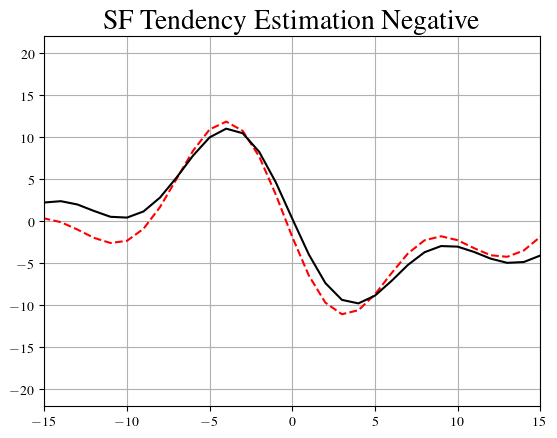

CPU times: user 17.6 s, sys: 279 ms, total: 17.9 s
Wall time: 18.4 s


In [11]:
%%time 

Pat_day_M = feldstein_out_roll.sel(time=NAO_dats_plus+np.timedelta64(0,'D'))['StreamFunction_L'].sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).mean('time')

t1_tan = project_pat_FBS(feldstein_out_roll,Pat_day_M,'T1',lat_ar,lon_ar,NAO_dats_plus)
t2_tan = project_pat_FBS(feldstein_out_roll,Pat_day_M,'T2',lat_ar,lon_ar,NAO_dats_plus)
t3_tan = project_pat_FBS(feldstein_out_roll,Pat_day_M,'T3',lat_ar,lon_ar,NAO_dats_plus)
t3_1_tan = project_pat_FBS(feldstein_out_roll,Pat_day_M,'T3_1',lat_ar,lon_ar,NAO_dats_plus)
t3_2_tan = project_pat_FBS(feldstein_out_roll,Pat_day_M,'T3_2',lat_ar,lon_ar,NAO_dats_plus)
term_actual = project_pat_FBS(feldstein_out_roll,Pat_day_M,'StreamFunction_tend',lat_ar,lon_ar,NAO_dats_plus)


plt.plot(np.arange(-40,40),(t3_tan*1+t2_tan+t1_tan)*86400*1e7,label='simulated',color='r',linestyle='--')
# plt.plot(np.arange(-40,40),(t3_1_tan)*86400*1e7,label='simulated',color='r',linestyle='--')

plt.plot(np.arange(-40,40),(term_actual)*1e7,label='actual',color='k',linestyle='-')
plt.xlim([-15,15])
plt.ylim([-22,22])
plt.grid(True)
plt.title('SF Tendency Estimation Negative',fontsize=20)
plt.show()

DS_proj_plus = xr.Dataset({'t1_tan_plus': (['index'], t1_tan*86400),
                              't2_tan_plus': (['index'], t2_tan*86400),
                              't3_tan_plus': (['index'], t3_tan*86400),
                              't3_1_tan_plus': (['index'], t3_1_tan*86400),
                              't3_2_tan_plus': (['index'], t3_2_tan*86400),
                              'term_tend_plus': (['index'], term_actual)
                             },
                coords={'index': np.arange(-40,40)})

DSmerge = xr.merge([DS_pc_composite,DS_proj_plus])
DSmerge.to_netcdf('/glade/work/wchapman/DA_ML/notebooks/Figures/StreamFunction_Tendency/Figures_out/NAO/NAO_proj_and_pcs_'+modvers_comp+'.nc')


In [12]:
'/glade/work/wchapman/DA_ML/notebooks/Figures/StreamFunction_Tendency/Figures_out/NAO/NAO_TAN_proj_and_pcs_'+modvers_comp+'.nc'

'/glade/work/wchapman/DA_ML/notebooks/Figures/StreamFunction_Tendency/Figures_out/NAO/NAO_TAN_proj_and_pcs_ERAi.h1.nc'